In [18]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
#from keras.applications import inception_v3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [19]:
# re-size all the images to this
IMAGE_SIZE = [48, 48]


In [20]:
train_path="D:/RAD/RAD_Model/RAD/train"
test_path="D:/RAD/RAD_Model/RAD/test"
val_path="D:/RAD/RAD_Model/RAD/val"

In [21]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(48,48))
        x_train.append(img_arr)

In [22]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(48,48))
        x_test.append(img_arr)
    

In [23]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(48,48))
        x_val.append(img_arr)
    

In [24]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [25]:
train_x.shape,test_x.shape,val_x.shape

((2635, 48, 48, 3), (645, 48, 48, 3), (139, 48, 48, 3))

In [26]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# train_datagen = ImageDataGenerator(rescale = 1./255)

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (48, 48),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (48, 48),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (48, 48),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 2635 images belonging to 4 classes.
Found 645 images belonging to 4 classes.
Found 139 images belonging to 4 classes.


In [29]:
training_set.class_indices

{'Accident': 0, 'Fight': 1, 'Fire': 2, 'Snatching': 3}

In [30]:
train_y=training_set.classes

In [31]:
test_y=test_set.classes

In [32]:
val_y=val_set.classes

In [33]:
train_y.shape,test_y.shape,val_y.shape

((2635,), (645,), (139,))

In [34]:
# add preprocessing layer to the front of VGG
vgg = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [35]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [36]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

In [37]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [38]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [40]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=30,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/30
83/83 [==============================] - 24s 181ms/step - loss: 0.8963 - accuracy: 0.6786 - val_loss: 0.5594 - val_accuracy: 0.8705
Epoch 2/30
83/83 [==============================] - 12s 150ms/step - loss: 0.4377 - accuracy: 0.8896 - val_loss: 0.4109 - val_accuracy: 0.8849
Epoch 3/30
83/83 [==============================] - 12s 150ms/step - loss: 0.3244 - accuracy: 0.9180 - val_loss: 0.2750 - val_accuracy: 0.9065
Epoch 4/30
83/83 [==============================] - 12s 149ms/step - loss: 0.2417 - accuracy: 0.9491 - val_loss: 0.1964 - val_accuracy: 0.9424
Epoch 5/30
83/83 [==============================] - 12s 151ms/step - loss: 0.1893 - accuracy: 0.9651 - val_loss: 0.1707 - val_accuracy: 0.9424
Epoch 6/30
83/83 [==============================] - 12s 150ms/step - loss: 0.1544 - accuracy: 0.9776 - val_loss: 0.1500 - val_accuracy: 0.9640
Epoch 7/30
83/83 [==============================] - 12s 149ms/step - loss: 0.1294 - accuracy: 0.9822 - val_loss: 0.1292 - val_accuracy: 0.9712

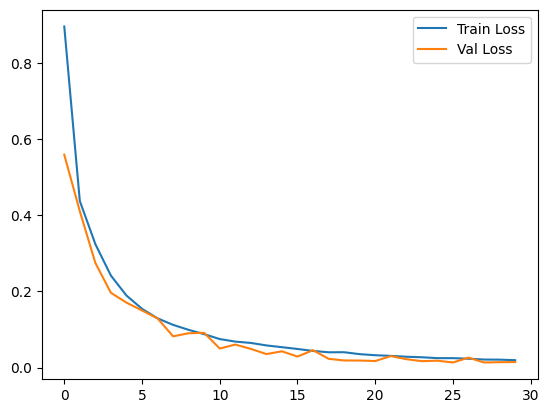

In [41]:
# loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

plt.savefig('ResNet50_loss.png')
plt.show()

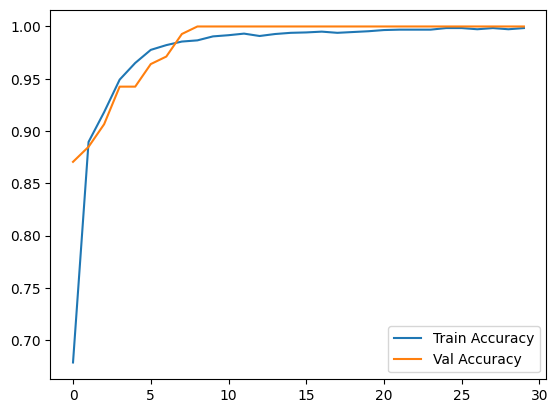

In [42]:
# accuracies
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()

plt.savefig('ResNet50_Acc.png')
plt.show()

In [43]:
model.evaluate(test_x,test_y,batch_size=32)

21/21 [==============================] - 5s 222ms/step - loss: 0.2833 - accuracy: 0.9194


[0.2832571268081665, 0.9193798303604126]

In [44]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [45]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [46]:
accuracy_score(y_pred,test_y)

0.9193798449612403

In [48]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       291
           1       0.97      1.00      0.98       150
           2       0.53      1.00      0.69        53
           3       1.00      0.99      0.99       151

    accuracy                           0.92       645
   macro avg       0.87      0.95      0.89       645
weighted avg       0.95      0.92      0.93       645



In [49]:
confusion_matrix(y_pred,test_y)

array([[241,   3,  47,   0],
       [  0, 150,   0,   0],
       [  0,   0,  53,   0],
       [  0,   2,   0, 149]], dtype=int64)

Confusion Matrix :
[[241   3  47   0]
 [  0 150   0   0]
 [  0   0  53   0]
 [  0   2   0 149]]
Accuracy Score : 0.9193798449612403
Report : 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       291
           1       0.97      1.00      0.98       150
           2       0.53      1.00      0.69        53
           3       1.00      0.99      0.99       151

    accuracy                           0.92       645
   macro avg       0.87      0.95      0.89       645
weighted avg       0.95      0.92      0.93       645



<Axes: >

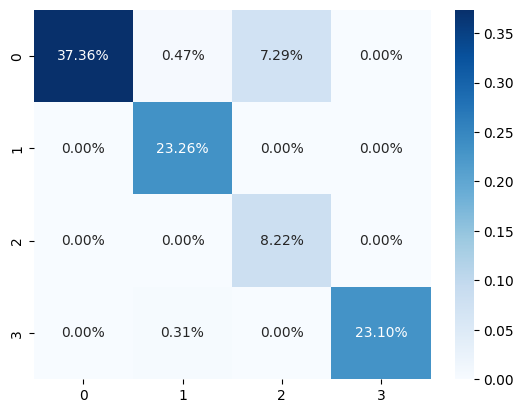

In [50]:
import seaborn as sns
from sklearn.metrics import accuracy_score
results = confusion_matrix(y_pred,test_y)
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(y_pred,test_y)) 
print('Report : ')
print(classification_report(y_pred,test_y))

sns.heatmap(results/np.sum(results), annot=True, 
            fmt='.2%', cmap='Blues')

[Text(0, 0.5, 'Accident'),
 Text(0, 1.5, 'Fight'),
 Text(0, 2.5, 'Car_Fire'),
 Text(0, 3.5, 'Snatching')]

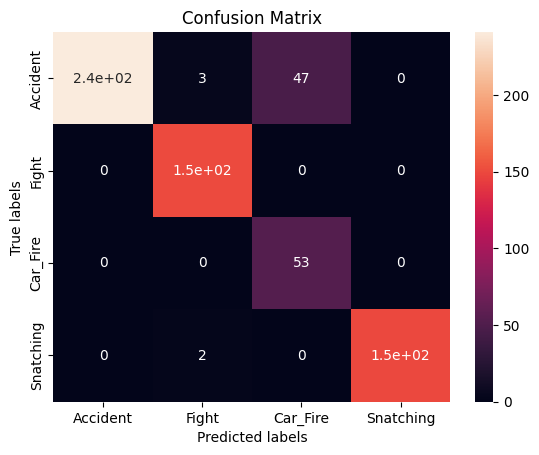

In [53]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Accident', 'Fight', 'Car_Fire','Snatching']); ax.yaxis.set_ticklabels(['Accident', 'Fight', 'Car_Fire','Snatching'])